## UnderStat is a website detailing results and stats from top tier football matches

The purpose of this notebook is to scrape Understat of all data related to final league positions and match statistics from the past 7 years for the top 5 leagues in world football

In [1]:
#packages used
import numpy as np
import pandas as pd 
import requests 
from bs4 import BeautifulSoup as bs 
import ast 
import json
from selenium import webdriver
import time
from PIL import Image
import matplotlib.pyplot as plot

There are two methods we can use to get league positions. The first is to scrape the browser-shown data from each league as below


In [2]:
driver = webdriver.Chrome()
sample_url = "https://understat.com/league/EPL/2018"

driver.get(sample_url)
time.sleep(5)
#scrape the 'table'
table_outline = driver.find_element_by_xpath('//div[contains(@id, "league-chemp")]')
table = table_outline.find_element_by_tag_name('table')
print(table.text)


№ Team M W D L G GA PTS xG xGA xPTS
1 Manchester City 38 32 2 4 95 23 98 93.72-1.28 25.73+2.73 90.64-7.36
2 Liverpool 38 30 7 1 89 22 97 79.46-9.54 29.15+7.15 83.45-13.55
3 Chelsea 38 21 9 8 63 39 72 63.97+0.97 38.11-0.89 71.45-0.55
4 Tottenham 38 23 2 13 67 39 71 61.75-5.25 49.15+10.15 61.44-9.56
5 Arsenal 38 21 7 10 73 51 70 64.80-8.20 57.30+6.30 58.97-11.03
6 Manchester United 38 19 9 10 65 54 66 68.62+3.62 52.30-1.70 61.86-4.14
7 Wolverhampton Wanderers 38 16 9 13 47 46 57 53.06+6.06 42.69-3.31 59.91+2.91
8 Everton 38 15 9 14 54 46 54 53.87-0.13 49.31+3.31 55.54+1.54
9 Leicester 38 15 7 16 51 48 52 52.11+1.11 44.64-3.36 56.24+4.24
10 West Ham 38 15 7 16 52 55 52 47.96-4.04 65.66+10.66 43.72-8.28
11 Watford 38 14 8 16 52 59 50 51.73-0.27 63.29+4.29 46.00-4.00
12 Crystal Palace 38 14 7 17 51 53 49 50.64-0.36 52.80-0.20 51.93+2.93
13 Newcastle United 38 12 9 17 42 48 45 39.91-2.09 57.55+9.55 39.22-5.78
14 Bournemouth 38 13 6 19 56 70 45 58.81+2.81 62.42-7.58 51.49+6.49
15 Burnley 38 1

We could then split up each line (sep = '\n') and each stat (sep = ' ') and iterate across all the leagues.



## Scraping UnderStat Using Scripts

However, because we want to also get the individual match stats we will not use this method, instead looking at the data behind the site in scripts behind the netwokr - response tab of 'inspect'

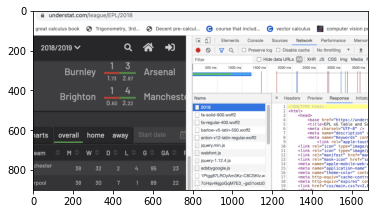

In [28]:
screenshot_of_network = '/Users/jacoblourie/Desktop/Understat_screenshot.png'
im = Image.open(screenshot_of_network)
plot.imshow(im)
plot.show()

In those scripts, there are references to teamdata and player_data. We need the team data. Let's take a look at what one of the teams data sections looks like now

In [21]:
#Initialise beautifulsoup package as we don't need to 'crawl' the site.
req = requests.get(sample_url)
html = req.content
soup = bs(html, 'lxml')

#access the scripts
scripts = soup.find_all('script')

counter = 0 #to check how many teamsdata scripts there are
#look through all the 'scripts'
for script in scripts:

    #get the contents of all those scripts
    contents = script.contents
    for content in contents:

        #we're looking for to check we can find a 'teamsdata' one, and see what it looks like
        if 'teamsData' in content:
            teams_data = content
            print(f"Beginning of content looks like this: {teams_data[0:500]}") #print the first 500 characters 
            print(f"\nEnd of content looks like this: \n {teams_data[len(content)-100:]}") #print last 100 characters 
            counter +=1

print(f"\nthere are {counter} scripts with the word 'teamsdata' in them ")

print(f" the teams data is of data type: {type(teams_data)}")

Beginning of content looks like this: 
	var teamsData = JSON.parse('\x7B\x2272\x22\x3A\x7B\x22id\x22\x3A\x2272\x22,\x22title\x22\x3A\x22Everton\x22,\x22history\x22\x3A\x5B\x7B\x22h_a\x22\x3A\x22a\x22,\x22xG\x22\x3A0.7153819999999999623696567141450941562652587890625,\x22xGA\x22\x3A0.8910379999999999967030817060731351375579833984375,\x22npxG\x22\x3A0.7153819999999999623696567141450941562652587890625,\x22npxGA\x22\x3A0.8910379999999999967030817060731351375579833984375,\x22ppda\x22\x3A\x7B\x22att\x22\x3A312,\x22def\x22\x3A20\x7D,\x22ppd

End of content looks like this: 
 x3A0,\x22npxGD\x22\x3A\x2D0.8181089999999999751167933936812914907932281494140625\x7D\x5D\x7D\x7D');


there are 1 scripts with the word 'teamsdata' in them 
 the teams data is of data type: <class 'bs4.element.Script'>


## Turning this data into something usable

Great, so we have a teamsdata script, and it seems to be in a bs4.element.Script form

We can handle this by first encoding to utf8 & then decoding

In [26]:
string_of_teams_data = teams_data.encode('utf8').decode('unicode_escape')
print(f"We now have data of type: {type(string_of_teams_data)}")
print(f"first 100 characters are: {string_of_teams_data[:100]}")
print(f"Last 100 characters are: {string_of_teams_data[len(string_of_teams_data)-100:]}")

We now have data of type: <class 'str'>
first 100 characters are: 
	var teamsData = JSON.parse('{"72":{"id":"72","title":"Everton","history":[{"h_a":"a","xG":0.715381
Last 100 characters are: ,"draws":0,"loses":1,"pts":0,"npxGD":-0.8181089999999999751167933936812914907932281494140625}]}}');



After repeating this with a few of the other URLs, the lengths are different but the format is the same. So first, let's get the bit which is actually a JSON from here:

In [30]:
start_index = string_of_teams_data.index("('") #this is the bit before the first '{'}
end_index = string_of_teams_data.index("\');\n") #this is the bit before the last '}'
json_data_cleaned = string_of_teams_data[start_index+2:end_index]
print(f"first 100 characters are: {json_data_cleaned[:100]}")
print(f"Last 100 characters are: {json_data_cleaned[len(string_of_teams_data)-100:]}")

first 100 characters are: {"72":{"id":"72","title":"Everton","history":[{"h_a":"a","xG":0.715381999999999962369656714145094156
Last 100 characters are: npxGD":-0.8181089999999999751167933936812914907932281494140625}]}}
